## Import libraries

In [ ]:
# !pip install -q segmentation-models

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, Flatten, Dense, Dropout, Rescaling, concatenate
import tensorflow.keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
import matplotlib.pyplot as plt

## Choosing model
Popular model for image segmentation is UNet. I could possibly use pretrained model and fine-tune it to my task or at least use some backbone like vgg or resnet for encoder part but since my dataset is quite small i will build my own UNet model

In [ ]:
def encoder_block(inputs,filters,drop):
  conv = Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
  conv = Dropout(drop)(conv)
  conv = Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
  pool = MaxPooling2D((2, 2))(conv)
  return conv,pool

def bridge(inputs,filters,drop):
  conv = Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
  conv = Dropout(drop)(conv)
  conv = Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
  return conv

def decoder_block(inputs,skip,filters,drop):
  conv = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(inputs)
  conv = concatenate([conv, skip])
  conv = Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
  conv = Dropout(drop)(conv)
  conv = Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv)
  return conv

def create_UNet(patch_size,filters):
    inputs = Input((patch_size, patch_size, 3))
    c1,p1 = encoder_block(inputs,filters,0.1)
    c2,p2 = encoder_block(p1,filters*2,0.1)
    c3,p3 = encoder_block(p2,filters*3,0.2)
    c4,p4 = encoder_block(p3,filters*4,0.2)
    c5 = bridge(p4,filters*5,0.3)
    c6 = decoder_block(c5,c4,filters*4,0.2)
    c7 = decoder_block(c6,c3,filters*3,0.2)
    c8 = decoder_block(c7,c2,filters*2,0.1)
    c9 = decoder_block(c8,c1,filters,0.1)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    return Model(inputs=[inputs], outputs=[outputs])

## Loss function and metrics
I chose 3 loss functions that are often chosen for image segmentation and additionally they are quite good at handling an unbalanced class data set. According to articles 2 good metrics to measure model quality for this type of task are F1 and IoU, but I will also check precision and recall. I selected class weights based on the percentage of occurrences of a given class in the set. I choose one of the loss functions based on the later result.

In [ ]:
metrics=[
  'f1_score',
  'iou_score',
  'precision',
  'recall'
  ]
loss_type=[
  'BinaryFocalLoss',
  'JaccardLoss',
  'DiceLoss'
 ]
metrics=[getattr(sm.metrics, metric) for metric in metrics]
losses=[
    sm.losses.BinaryFocalLoss(gamma=1, alpha=0.92),
    sm.losses.JaccardLoss(class_weights=[0.08,0.92]),
    sm.losses.DiceLoss(class_weights=[0.08,0.92]),
]

## Data
So at this point i tried all my datasets. I trained my model with Jaccard Loss and iou score as metric. Cropped and resized data with patches of size 64 received similar resuls around 0.2 IoU score on test dataset. Training on data with patch size 32 give some really bad results, even after changing amount of filters and learning rate the result does not improve.

## Load data and normalize

In [ ]:
with np.load('/content/drive/MyDrive/Sed/data_cropped_64.npz') as data:
    X_train = data['X_train']/255
    X_test = data['X_test']/255
    y_train = data['y_train']/255
    y_test = data['y_test']/255

In [ ]:
model=create_UNet(patch_size=64,filters=16)
optimizer=tf.keras.optimizers.Adam(0.0001)
model.compile(optimizer = optimizer, loss = losses[1], metrics = metrics)

In [ ]:
model_history = model.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=150)

## Selecting loss function

In [ ]:
callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            '/content/model.h5', 
            save_best_only=True, 
            restore_best_weights=True, 
            monitor="iou_score",
            mode="max"
        ),
        tf.keras.callbacks.EarlyStopping(
            patience=10, 
            monitor="iou_score",
            mode="max"
        )
    ]

loss_history=[]
for idx, loss in enumerate(losses):
  model = create_UNet(patch_size=64,filters=16)
  optimizer=tf.keras.optimizers.Adam(0.0001)
  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  model = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=150, verbose=0, callbacks=callbacks)
  loss_history.append(model)
  model = tf.keras.models.load_model('/content/model.h5',compile=False)
  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  _, f1, iou, precision, recall = model.evaluate(X_test, y_test)
  print(loss_type[idx], [f1, iou, precision, recall])
  model.save(f'/content/model_{loss_type[idx]}.h5')

3/3 [==============================] - 1s 9ms/step - loss: 0.0641 - f1-score: 0.2425 - iou_score: 0.1380 - precision: 0.1499 - recall: 0.6353
BinaryFocalLoss [0.24249136447906494, 0.13799028098583221, 0.14990796148777008, 0.6353170871734619]
3/3 [==============================] - 1s 12ms/step - loss: 0.9094 - f1-score: 0.3070 - iou_score: 0.1813 - precision: 0.2050 - recall: 0.6274
JaccardLoss [0.3069840371608734, 0.18133799731731415, 0.20501886308193207, 0.627447783946991]
3/3 [==============================] - 1s 12ms/step - loss: 0.8410 - f1-score: 0.3180 - iou_score: 0.1893 - precision: 0.2098 - recall: 0.6632
DiceLoss [0.3180268108844757, 0.1893252283334732, 0.20979677140712738, 0.6632193922996521]


## Data augmentation
My best received results so far oscillate around 20% IoU Score on the validation data. My model is overfitted because of small training size. I'll try to make some augmentation to improve score a little bit.

In [ ]:
train_datagen = ImageDataGenerator(
    # rotation_range=15,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # zoom_range = 0.1,
    vertical_flip=True,
    horizontal_flip = True,
    )

train_generator = train_datagen.flow(
    X_train,
    y_train,
    batch_size = 32)  

batch_size = 32
steps_per_epoch = len(X_train) // batch_size  

model=create_UNet(patch_size=64,filters=16)
optimizer=tf.keras.optimizers.Adam(0.00001)
model.compile(optimizer = optimizer, loss = losses[2], metrics = metrics[1])
model.fit(train_generator,validation_data=(X_test, y_test),steps_per_epoch = steps_per_epoch, epochs=150, verbose=0, callbacks=callbacks)
model = tf.keras.models.load_model('/content/model.h5',compile=False)
model.compile(optimizer = optimizer, loss = losses[1], metrics = metrics)
_, f1, iou, precision, recall = model.evaluate(X_test, y_test)

3/3 [==============================] - 1s 10ms/step - loss: 0.9054 - f1-score: 0.3180 - iou_score: 0.1893 - precision: 0.2098 - recall: 0.6632


## Results
My model is overfitting due to lack of data. I tried to improve my result by data augmentation but it didn't affected score. Below i present a few comparison between of actual data with predictions.

In [ ]:
def plot_images_in_row(images):
    fig, axarr = plt.subplots(1, 3, figsize=(10, 10))
    labels = ['Image', 'Mask', 'Prediction']
    for i in range(3):
        axarr[i].imshow(images[i])
        axarr[i].set_title(labels[i])
    plt.show()

def load_and_predict(path,loss_num):
  model = tf.keras.models.load_model(path,compile=False)
  model.compile(optimizer = optimizer, loss = losses[loss_num], metrics = metrics)
  _, f1, iou, precision, recall = model.evaluate(X_test, y_test)

  predictions=model.predict(X_test, verbose=0)

  for i in range(5):
    images = [X_test[i], y_test[i], predictions[i]]
    plot_images_in_row(images)

3/3 [==============================] - 1s 11ms/step - loss: 0.9094 - f1-score: 0.3070 - iou_score: 0.1813 - precision: 0.2050 - recall: 0.6274


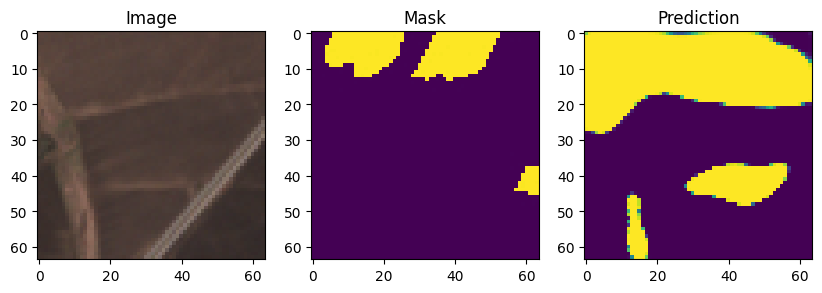

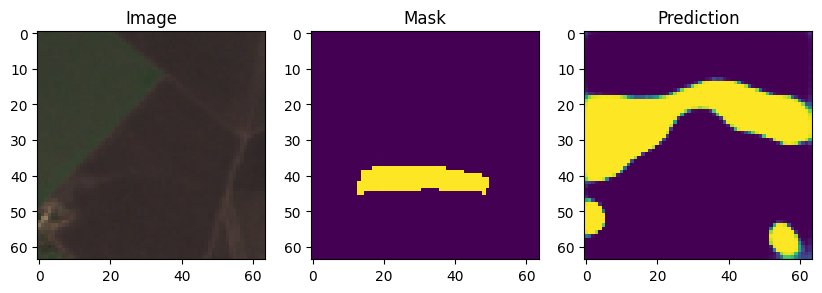

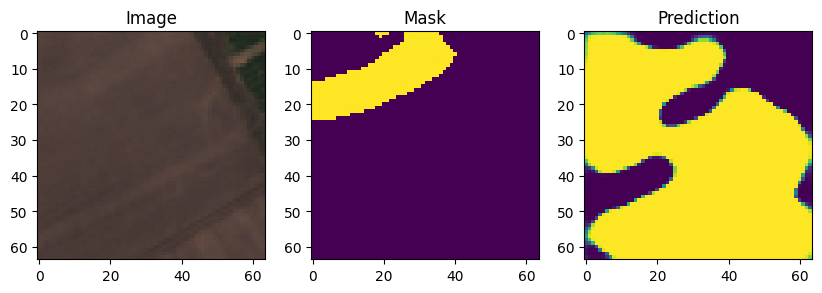

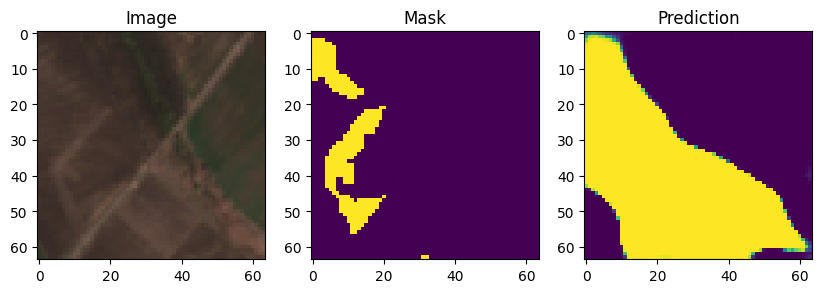

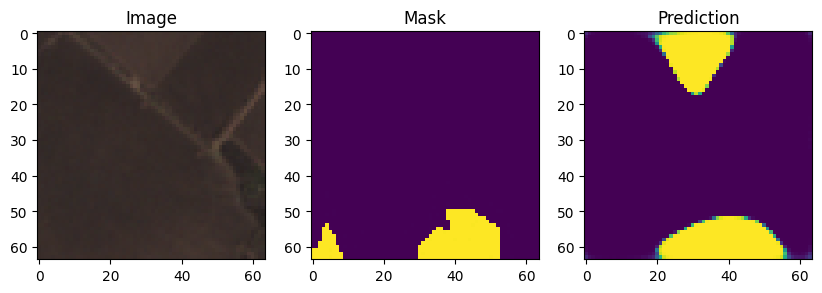

In [ ]:
load_and_predict('/content/model_JaccardLoss.h5',1)

3/3 [==============================] - 1s 16ms/step - loss: 0.9054 - f1-score: 0.3180 - iou_score: 0.1893 - precision: 0.2098 - recall: 0.6632


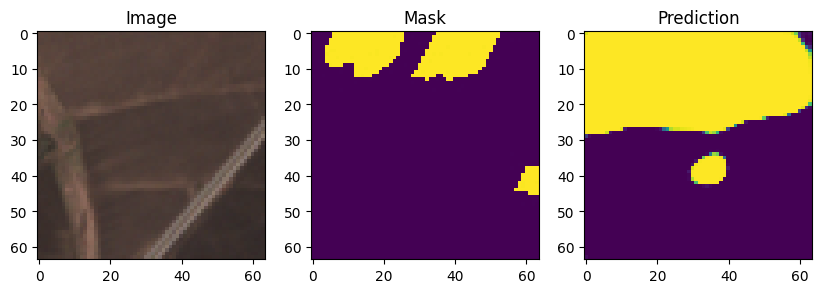

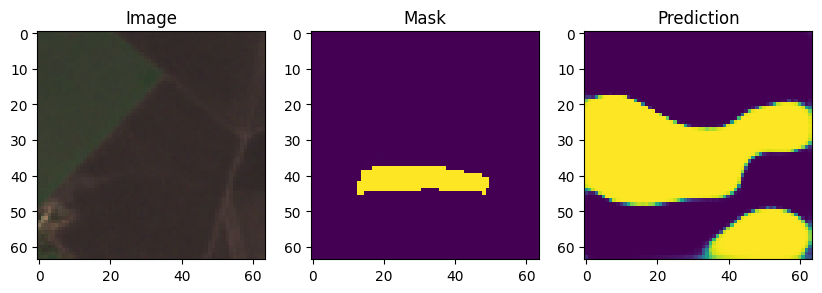

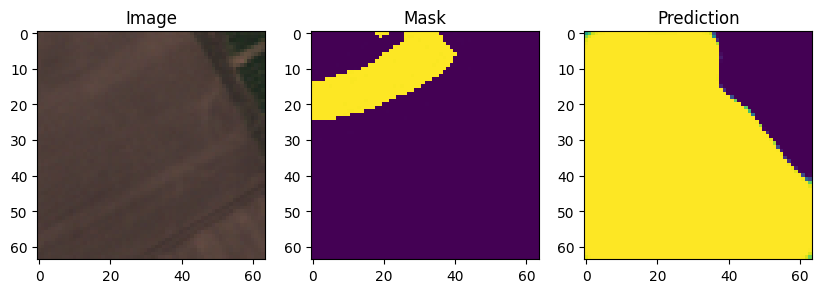

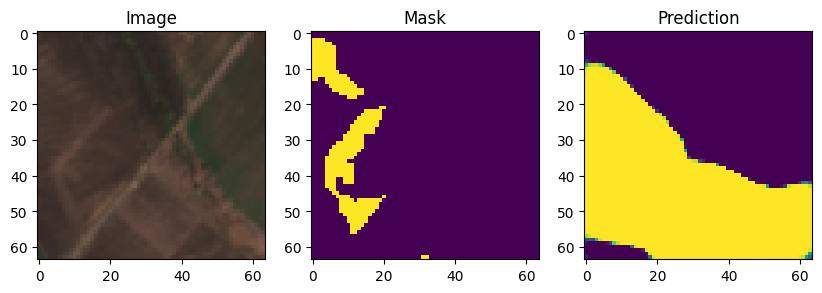

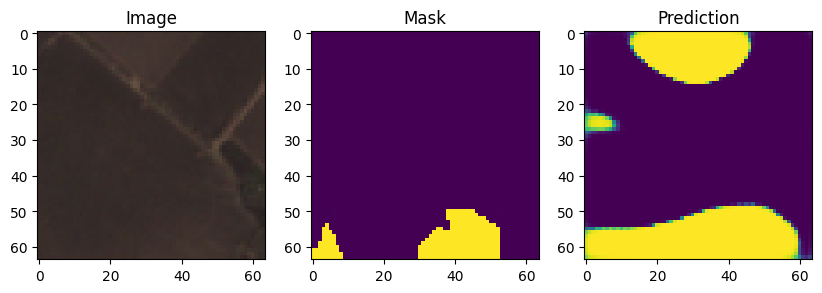

In [ ]:
load_and_predict('/content/model_DiceLoss.h5',1)